In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import visdom
vis = visdom.Visdom()

The Gaussian clocking method for each neuron $n$ is defined as:

$$
clk_{n} \sim \mathcal{N}(0, 1) \\
g_{n,t} = clk_{n} \cdot \sigma_{n} + \mu_{n} \\
\hat{y}_{n,t} = f(w_{n} x_{t} + u_{n} y_{n, t-1} + b_{n}) \\
y_{n,t} = g_{n,t} \hat{y}_{n,t} + (1 - g_{n,t}) y_{n,t}
$$

where $x_t$ is the current input, $y_{n,t}$ the output. $\mu_{n}$, $\sigma_{n}$, $w$, $u$ and $b$ are learnable parameters.

### Logging callbacks

In [272]:
class GradLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern, debug_print=False):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        self.debug_print = debug_print
        
    def on_grad_computed(self, net, named_parameters, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), named_parameters)
        for name, param in param_pairs:
            history_name = 'grad_' + name
            net.history.record_batch(history_name, param.grad.abs().mean().item())
            self.to_accumulate_.add(history_name)
            if self.debug_print:
                print(param.grad.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)

In [6]:
class ParamLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        
    def on_batch_end(self, net, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            history_name = 'mean_' + name
            net.history.record_batch(history_name, param.mean().item())
            self.to_accumulate_.add(history_name)
            #print(param.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)

In [7]:
class ParamPrinter(skorch.callbacks.Callback):
    def __init__(self, param_pattern, mode='batch', format='{}'):
        self.param_pattern = param_pattern
        self.mode = mode
        self.format = format
        
    def print_params(self, net):
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            print([self.format.format(n) for n in param.data.tolist()])
        
    def on_batch_end(self, net, **kwargs):        
        if self.mode != 'batch':
            return
        self.print_params(net)
            
    def on_epoch_end(self, net, **kwargs):
        if self.mode != 'epoch':
            return
        self.print_params(net)   

### Modules

In [255]:
class GaussClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', 
                 non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.m = nn.Parameter(torch.ones(hidden_dim) - 0.5)
        self.s = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        #torch.nn.init.uniform_(self.m.data, 0, 1)
        #torch.nn.init.uniform_(self.s.data, 0.01, 0.1)
        torch.nn.init.normal_(self.m.data, mean=0.5, std=0.5)
        torch.nn.init.normal_(self.s.data, mean=0.0, std=0.1)
        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        clks = torch.randn(x.size(1), self.hidden_dim).to(x)
        clks = F.sigmoid(clks * self.s + self.m)

        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = clks[ti]
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y = clock_gate * self.act(h_new) + (1 - clock_gate) * h
                h = y
            else:
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [308]:
temp = 0.1
num_hid = 4
t = 100
clk = torch.ones(num_hid, 2)
clk[0, 0] = 1
clk[0, 1] = 0.1
u = torch.rand(t, num_hid, 2)
u = -torch.log(-torch.log(u))
clks = F.softmax((clk.log() + u) / temp, dim=-1)

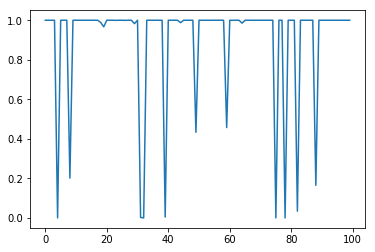

In [309]:
plt.plot(clks[:, 0, 0].data.numpy())

In [320]:
class GumbelClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', 
                 non_linear_state=False, temp=1.,
                ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        self.temp = temp
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.clk = nn.Parameter(torch.ones(hidden_dim, 2))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        #torch.nn.init.uniform_(self.clk.data, 0.01, 0.1)
        torch.nn.init.uniform_(self.clk.data[:, 0], 0.1, 1)
        torch.nn.init.uniform_(self.clk.data[:, 1], 0.1, 1)
        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        
        u = torch.rand(x.size(1), self.hidden_dim, 2).to(x)
        u = -torch.log(-torch.log(u))
        clks = F.softmax((self.clk.clamp(min=0.01).log() + u) / self.temp, dim=-1)

        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = clks[ti]
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y = clock_gate[:, 0] * self.act(h_new) + clock_gate[:, 1] * h
                h = y
            else:
                h = clock_gate[:, 0] * h_new + clock_gate[:, 1] * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [321]:
class IRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', 
                 non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim #+ 1
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        ys = []
        cs = []
        for ti in range(x.size(1)):
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y =  self.act(h_new)
                h = y
            else:
                h = h_new
                y = self.act(h)
            ys.append(y)
            cs.append(y)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

### Data creation

In [322]:
def get_batch(batch_size, time_steps, random_state=0):
    """Generate the adding problem dataset"""
    rng = np.random.RandomState(seed=random_state)
    
    # Build the first sequence
    add_values = rng.rand(batch_size, time_steps)
    add_values = add_values.astype('float32')

    # Build the second sequence with one 1 in each half and 0s otherwise
    add_indices = np.zeros_like(add_values)
    half = int(time_steps / 2)
    for i in range(batch_size):
        first_half = rng.randint(half)
        second_half = rng.randint(half, time_steps)
        add_indices[i, [first_half, second_half]] = 1

    # Zip the values and indices in a third dimension:
    # inputs has the shape (batch_size, time_steps, 2)
    inputs = np.dstack((add_values, add_indices))
    targets = np.sum(np.multiply(add_values, add_indices), axis=1)
    return inputs, targets.reshape(-1, 1)

In [323]:
class AddDataset(torch.utils.data.Dataset):
    def __init__(self, n_timesteps, length=200, random_state=0):
        self.n_timesteps = n_timesteps
        self.length = length
        self.rng_ = np.random.RandomState(seed=random_state)
    def __getitem__(self, i):
        Xi, yi = get_batch(1, self.n_timesteps, random_state=self.rng_.randint(1e8))
        return Xi[0], yi[0]
    def __len__(self):
        return self.length

In [324]:
T = 100
dataset_train = AddDataset(n_timesteps=T, length=200)
X_valid, y_valid = get_batch(200, T, random_state=1)

### Task Model

In [325]:
class AdditionModel(nn.Module):
    def __init__(self, num_hidden=64, act='relu', num_layers=1, visdom=False, 
                 rnn_type='gauss', non_linear_state=False, temp=1.):
        super().__init__()
        
        self.visdom = visdom
        self.rnn = []
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        for i in range(num_layers):
            input_dim = 2 if i == 0 else num_hidden
            output_dim = num_hidden
            if rnn_type == 'gauss':
                self.rnn.append(GaussClocking(input_dim, output_dim, 
                                              act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'gumbel':
                self.rnn.append(GumbelClocking(input_dim, output_dim, 
                                               act=act, non_linear_state=non_linear_state, temp=temp))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'irnn':
                self.rnn.append(IRNN(input_dim, output_dim, 
                                     act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'gru':
                self.rnn.append(nn.GRU(input_dim, output_dim, batch_first=True))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        self.cis = [None] * self.num_layers
        for i in range(self.num_layers):
            if self.rnn_type == 'gru':
                li, hi = self.rnn[i](li)
                ci = None
            else:
                li, hi, ci = self.rnn[i](li)
            self.cis[i] = ci
            if self.visdom:
                vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
                if ci is not None:
                    vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clocks rnn'+str(i)}, win="clocks rnn"+str(i))
        return self.clf(li[:, -1])

In [326]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss, # ignored, we overwrite get_loss
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        return (y_pred - y_true).abs().mean(-1).mean()

In [329]:
torch.manual_seed(1333)

def my_train_split(ds, y):
    return ds, skorch.dataset.Dataset(X_valid, y_valid)

ef = Trainer(module=AdditionModel,
             optimizer=torch.optim.RMSprop,
             lr=0.0002,
             max_epochs=300,
             train_split=my_train_split,
             
             module__num_hidden=50,
             module__act='relu',
             module__num_layers=1,
             module__visdom=False,
             module__rnn_type='gumbel',
             module__non_linear_state=False,
             module__temp=0.1,
             
             #iterator_train=train_iterator,
             #iterator_train__n_batches=200,
             #iterator_train__n_timesteps=100,
             #iterator_train__shuffle=True,
             
             device='cpu',
             batch_size=16,
            
             optimizer__param_groups=[
                 #('rnn*.clk', {'lr': 0.0002}),
                 ('rnn*.m', {'lr': 0.2}),
                 #('rnn*.s', {'lr': 0.02}),
             ],
             
             callbacks=[
                 #skorch.callbacks.ProgressBar(),
                 #('mae_valid', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_valid', lower_is_better=False)),
                 #('mae_train', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_train', lower_is_better=False, on_train=True)),
                 ('grad_log_1', GradLogger('rnn*.i2h.weight')),
                 ('grad_log_2', GradLogger('rnn*.h2h.*')),
                 ('grad_log_3', GradLogger('rnn*.[ms]')),
                 ('grad_log_4', GradLogger('rnn*.clk')),
                 #('parm_log_1', ParamPrinter('rnn*.m', mode='epoch', format='{:.3f}')),
                 skorch.callbacks.GradientNormClipping(gradient_clip_value=10),
             ]
            )

In [330]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.clk    grad_rnn0.h2h.weight    grad_rnn0.i2h.weight    train_loss    valid_loss     dur
-------  ---------------  ----------------------  ----------------------  ------------  ------------  ------
      1           0.0963                  0.6124                  1.5238        1.1974        0.3574  0.7546
      2           0.0163                  0.0996                  0.3447        0.3433        0.4083  0.7491
      3           0.0206                  0.1219                  0.4276        0.3817        0.4574  0.8319
      4           0.0152                  0.0874                  0.3059        0.3580        0.5105  0.7330
      5           0.0101                  0.0633                  0.2274        0.3700        0.3530  0.7250
      6           0.0162                  0.0950                  0.3530        0.3723        0.3563  0.6754
      7           0.0113                  0.0629                  0.2379        0.3593 

     73           0.0047                  0.0224                  0.0810        0.3300        0.3432  0.7375
     74           0.0054                  0.0237                  0.0880        0.3446        0.3410  0.8519
     75           0.0050                  0.0245                  0.0931        0.3163        0.3442  0.8794
     76           0.0059                  0.0322                  0.1223        0.3620        0.3608  0.7074
     77           0.0080                  0.0366                  0.1350        0.3506        0.3531  0.7684
     78           0.0082                  0.0348                  0.1295        0.3416        0.3430  0.7645
     79           0.0049                  0.0227                  0.0870        0.3608        0.3441  0.7326
     80           0.0060                  0.0277                  0.1048        0.3370        0.3529  0.7634
     81           0.0065                  0.0298                  0.1194        0.3311        0.3512  0.7556
     82           0

    148           0.0041                  0.0229                  0.0812        0.3279        0.3495  0.8448
    149           0.0084                  0.0400                  0.1372        0.3454        0.3548  0.8445
    150           0.0041                  0.0179                  0.0643        0.2969        0.3405  0.8306
    151           0.0056                  0.0272                  0.0946        0.3622        0.3474  0.9005
    152           0.0039                  0.0210                  0.0720        0.3255        0.3419  1.1479
    153           0.0028                  0.0134                  0.0495        0.3535        0.3498  1.2514
    154           0.0037                  0.0159                  0.0624        0.3530        0.3445  1.1235
    155           0.0043                  0.0215                  0.0767        0.3503        0.3457  1.0602
    156           0.0029                  0.0181                  0.0629        0.3618        0.3493  1.0169
    157           0

    224           0.0036                  0.0191                  0.0648        0.3245        0.3523  0.7498
    225           0.0041                  0.0235                  0.0760        0.3389        0.3421  0.6925
    226           0.0047                  0.0221                  0.0742        0.3589        0.3520  0.7795
    227           0.0038                  0.0168                  0.0579        0.3273        0.3479  0.7668
    228           0.0047                  0.0231                  0.0804        0.3152        0.3402  0.7910
    229           0.0035                  0.0161                  0.0572        0.3163        0.3443  0.8372
    230           0.0040                  0.0164                  0.0561        0.3270        0.3411  0.8382
    231           0.0035                  0.0149                  0.0527        0.3495        0.3396  0.7595
    232           0.0046                  0.0189                  0.0713        0.3490        0.3383  0.8116
    233           0

    300           0.0042                  0.0205                  0.0658        0.3324        0.3403  0.8199


<class '__main__.Trainer'>[initialized](
  module_=AdditionModel(
    (rnn0): GumbelClocking(
      (i2h): Linear(in_features=2, out_features=50, bias=True)
      (h2h): Linear(in_features=50, out_features=50, bias=False)
      (act): ReLU()
    )
    (clf): Linear(in_features=50, out_features=1, bias=True)
  ),
)

### Look at clocks from last validation run

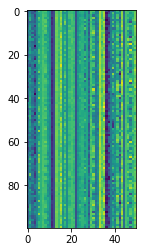

In [268]:
plt.imshow(ef.module_.cis[0].data.numpy());

Take a look at the 'clocking' for unit 0 - 9 over time:

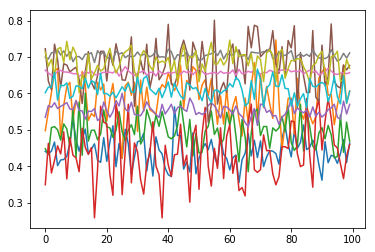

In [269]:
[plt.plot(ef.module_.cis[0].data.numpy()[:, n]) for n in range(10)];

Distribution of 'clocks' (mean values of Gaussians):

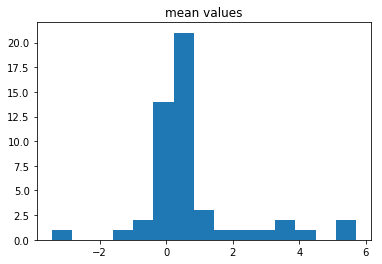

In [78]:
plt.hist(ef.module_.rnn[0].m.data.numpy(), bins=15);
plt.title('mean values');

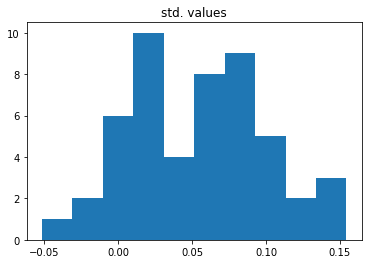

In [79]:
plt.hist(ef.module_.rnn[0].s.data.numpy(), bins=10);
plt.title('std. values');

### History of gradients during training

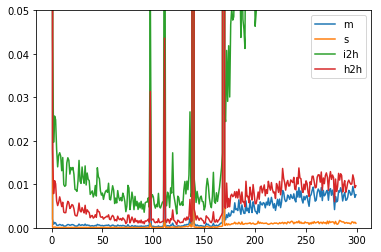

In [80]:
plt.plot(ef.history[:, 'grad_rnn0.m'])
plt.plot(ef.history[:, 'grad_rnn0.s'])
plt.plot(ef.history[:, 'grad_rnn0.i2h.weight']) # weights input -> hidden
plt.plot(ef.history[:, 'grad_rnn0.h2h.weight']) # weights hidden -> hidden
plt.legend(['m', 's', 'i2h', 'h2h'])
plt.ylim([0, .05]);

### Loss over time

(0, 1)

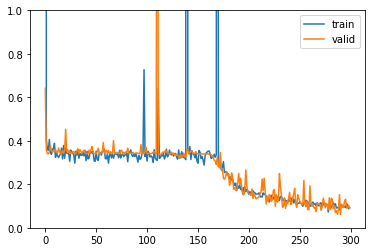

In [81]:
plt.plot(ef.history[:, 'train_loss'])
plt.plot(ef.history[:, 'valid_loss'])
plt.legend(['train', 'valid'])
plt.ylim([0, 1])